# Document's Features

#### · Display raw data from cluster

#### · Display raw data and located peaks recorded in cluster 

#### · Find peaks of recorder raw data with the most updated version of the algorithm 

In [1]:
import nirscloud_util_meta
import nirscloud_util_hdfs
import logging
import pandas as pd
import numpy as np
import plotly
import pyspark
import sys
from plotly.subplots import make_subplots
import math 
import plotly.graph_objects as go
import sys
import matplotlib.pyplot as plt
from numpy import matrix
from scipy.signal import find_peaks
from scipy import interpolate
import datetime
from scipy.signal import find_peaks,butter, lfilter, lfilter_zi, convolve,resample, correlate, iirnotch, filtfilt, stft
from scipy import signal


/usr/local/lib/python3.9/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install pymongo==3.13.0

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
#import util

In [4]:
my_name = 'braulio.ramirez'

In [5]:
logger = logging.getLogger('jhub')
hostname = 'mongos.mongo.svc.cluster.local:27017'
pemkeyfile = '/etc/mongo/jhub-keypem.pem'
sslca = '/etc/mongo/root-ca.pem'

nirscloud_util_meta.init(logger, 'meta', hostname=hostname, ssl=True, cert=pemkeyfile, ca=sslca)

In [6]:
spark_kerberos_principal = my_name + '@BABYNIRS.ORG'

params = {
    'spark_kerberos_principal': spark_kerberos_principal,
}
nirscloud_util_hdfs.init('/etc/jhub/conf/production.ini', params=params)

2023-06-21 19:21:42 [INFO ] cfg#_init_hdfs_kinit@79: after hdfs_kinit: the_stdout: b'' the_stderr: b''
2023-06-21 19:21:42 [INFO ] client#__init__@192: Instantiated <KerberosClient(url='https://hdfs2.babynirs.org:9870;https://hdfs1.babynirs.org:9870;https://hdfs4.babynirs.org:9870')>.


### Pulling the recorded peaks from the cluster

In [7]:
hdfs_path = '_device_id=Procyon/_bed_id=HA11-01/_the_date=2023-06-10/_hr=00/_patient_id=5984929'

In [8]:
kafka_topics = 'nk_rpeak2_NICU'
hdfs_prefix = '/kafka/topics/%s'% (kafka_topics)

In [9]:
def _get_df(hdfs_path, the_id):
    hdfs_path = hdfs_path
    full_path = nirscloud_util_hdfs.full_path(hdfs_prefix, hdfs_path)
    err, df = nirscloud_util_hdfs.from_hdfs_path(full_path)
    print(err, df)
    is_valid = df['id'] == the_id
    df = df[is_valid]
    return df

In [10]:
df_II_peaks = _get_df(hdfs_path, 'II')

2023-06-21 19:21:49 [INFO ] client#status@320: Fetching status for '/'.
2023-06-21 19:21:51 [INFO ] client#status@320: Fetching status for '/kafka/topics/nk_rpeak2_NICU/_device_id=Procyon/_bed_id=HA11-01/_the_date=2023-06-10/_hr=00/_patient_id=5984929'.
2023-06-21 19:21:52 [INFO ] client#status@320: Fetching status for '/'.
2023-06-21 19:21:54 [INFO ] client#status@320: Fetching status for '/kafka/topics/nk_rpeak2_NICU/_device_id=Procyon/_bed_id=HA11-01/_the_date=2023-06-10/_hr=00/_patient_id=5984929'.
2023-06-21 19:21:55 [INFO ] client#list@1123: Listing '/kafka/topics/nk_rpeak2_NICU/_device_id=Procyon/_bed_id=HA11-01/_the_date=2023-06-10/_hr=00/_patient_id=5984929'.
2023-06-21 19:21:57 [INFO ] client#list@1123: Listing '/kafka/topics/nk_rpeak2_NICU/_device_id=Procyon/_bed_id=HA11-01/_the_date=2023-06-10/_hr=00/_patient_id=5984929'.
2023-06-21 19:21:58 [INFO ] client#status@320: Fetching status for '/'.
2023-06-21 19:21:59 [INFO ] client#status@320: Fetching status for '/kafka/topics/

None       id             start_ns          rec_nano_ts       val      ver  \
0     II  1686372038314000000  1686372039283320820  1.149853  v0.0.23   
1     II  1686372038826000000  1686372039623391041  0.070611  v0.0.23   
2     II  1686372038826000000  1686372039963980267  0.471633  v0.0.23   
3     II  1686372039338000000  1686372040304866902  0.387760  v0.0.23   
4     II  1686372039850000000  1686372040645622712  0.322574  v0.0.23   
...   ..                  ...                  ...       ...      ...   
3476  II  1686373175978000000  1686373176977949007 -0.491993  v0.0.23   
3477  II  1686373176490000000  1686373177586859349  0.641429  v0.0.23   
3478  II  1686373177002000000  1686373178182592895  0.716261  v0.0.23   
3479  II  1686373177514000000  1686373178621707140  0.550078  v0.0.23   
3480  II  1686373178026000000  1686373179078254610  2.296289  v0.0.23   

     _device_id  _bed_id   _the_date _hr _patient_id  
0       Procyon  HA11-01  2023-06-10  00     5984929  
1       

In [11]:
df_II_peaks.sort_values(by=['rec_nano_ts'], inplace=True)
df_II_peaks.reset_index(drop=True, inplace=True)
df_II_peaks['shift_rec_nano_ts'] = df_II_peaks['rec_nano_ts'].shift(-1)
df_II_peaks['dif_rec_nano_ts'] = df_II_peaks['shift_rec_nano_ts'] - df_II_peaks['rec_nano_ts']
df_II_peaks;

In [12]:
values_p = np.asarray(df_II_peaks['val'].to_numpy())
raw_time_p = np.asarray(df_II_peaks['rec_nano_ts'].to_numpy(), dtype = 'int')
time_p = [np.datetime64(int(t),'ns') for t in raw_time_p]

## Pulling continuous signal data from cluster 

In [13]:
kafka_topics_cs = 'nk_waves_NICU'
hdfs_prefix_cs = '/nirscloud/agg_by_hr3/%s'% (kafka_topics_cs)

In [14]:
def _get_df_cs(hdfs_path, the_id):
    hdfs_path = hdfs_path + '/id=%s' % (the_id)
    full_path = nirscloud_util_hdfs.full_path(hdfs_prefix_cs, hdfs_path)
    err, df = nirscloud_util_hdfs.from_hdfs_path(full_path)
    return df

In [15]:
df_II_cs = _get_df_cs(hdfs_path, 'MDC_ECG_ELEC_POTL_II')
df_II_cs.sort_values(by=['_milli_ts'], inplace=True)
df_II_cs.reset_index(drop=True, inplace=True)
df_II_cs['shift_milli_ts'] = df_II_cs['_milli_ts'].shift(-1)
df_II_cs['diff_milli_ts'] = df_II_cs['shift_milli_ts'] - df_II_cs['_milli_ts']
df_II_cs;

2023-06-21 19:23:23 [INFO ] client#status@320: Fetching status for '/'.
2023-06-21 19:23:23 [INFO ] client#status@320: Fetching status for '/nirscloud/agg_by_hr3/nk_waves_NICU/_device_id=Procyon/_bed_id=HA11-01/_the_date=2023-06-10/_hr=00/_patient_id=5984929/id=MDC_ECG_ELEC_POTL_II'.
2023-06-21 19:23:23 [INFO ] client#status@320: Fetching status for '/'.
2023-06-21 19:23:23 [INFO ] client#status@320: Fetching status for '/nirscloud/agg_by_hr3/nk_waves_NICU/_device_id=Procyon/_bed_id=HA11-01/_the_date=2023-06-10/_hr=00/_patient_id=5984929/id=MDC_ECG_ELEC_POTL_II'.
2023-06-21 19:23:23 [INFO ] client#list@1123: Listing '/nirscloud/agg_by_hr3/nk_waves_NICU/_device_id=Procyon/_bed_id=HA11-01/_the_date=2023-06-10/_hr=00/_patient_id=5984929/id=MDC_ECG_ELEC_POTL_II'.
2023-06-21 19:23:23 [INFO ] client#status@320: Fetching status for '/nirscloud/agg_by_hr3/nk_waves_NICU/_device_id=Procyon/_bed_id=HA11-01/_the_date=2023-06-10/_hr=00/_patient_id=5984929/id=MDC_ECG_ELEC_POTL_II'.
2023-06-21 19:23:

In [16]:
values_cs = np.asarray(df_II_cs['val'].to_numpy())
raw_time_cs = np.asarray(df_II_cs['_milli_ts'].to_numpy(), dtype = 'int')
time_cs = [np.datetime64(int(t),'ms') for t in raw_time_cs]

In [17]:
time_pks = np.array([(pd.Timestamp(t).hour*60*60*1000) + (pd.Timestamp(t).minute*60*1000) + (pd.Timestamp(t).second*1000) + (pd.Timestamp(t).microsecond/1000) for t in time_p]);
time_cts = np.array([(pd.Timestamp(t).hour*60*60*1000) + (pd.Timestamp(t).minute*60*1000) + (pd.Timestamp(t).second*1000) + (pd.Timestamp(t).microsecond/1000) for t in time_cs]);
time_pks = time_pks - time_cts[0]; time_cts = time_cts - time_cts[0];

In [19]:
def time_f(time_array):

    mins = ((time_array/1000)/60).astype(int);
    sec = ((time_array/1000)%60).astype(int);
    mili = ((time_array - (mins*60*1000 + sec*1000))*100).astype(int)/100 #*100.astype(int)/100 is to round to two decimals

    return (np.array([str(minutes)+':'+str(seconds)+':'+str(milis) for minutes, seconds, milis in zip(mins,sec,mili)]))

In [20]:
class raw_sample_():
    
    def __init__(self,min_min,min_sec,max_min,max_sec,seconds_per_label):
        
        self.min_min = min_min
        self.min_sec = min_sec
        self.max_min = max_min
        self.max_sec = max_sec
        self.seconds_per_label = seconds_per_label

        self.min_time = int((self.min_min*60*1000)/4) + int(self.min_sec*1000/4)
        self.max_time = int((self.max_min*60*1000)/4) + int(self.max_sec*1000/4) + 1
        self.pks_time_min = (self.min_min*60*1000) + (self.min_sec*1000)
        self.pks_time_max = (self.max_min*60*1000) + (self.max_sec*1000)
        self.pks_time = time_pks[(self.pks_time_min > time_pks).argmin():(time_pks < self.pks_time_max).argmin()]
        self.pks_values = values_p[(self.pks_time_min > time_pks).argmin():(time_pks < self.pks_time_max).argmin()]
        
        self.time =time_cts[self.min_time:self.max_time]
        self.values = df_II_cs['val'].to_numpy()[self.min_time:self.max_time]

        self.fig = go.Figure()
        self.fig.add_trace(go.Scatter(line= dict(color='blue'),x=self.time, y=self.values,showlegend=False))
        self.fig.add_trace(go.Scatter(mode='markers', marker= dict(color='red'),x=self.pks_time, y=self.pks_values,showlegend=False))

        self.ticks_values = []
        x = self.time[0]
        while x < self.time[-1]:
            self.ticks_values = np.append(self.ticks_values,x)
            x = 1000*self.seconds_per_label + x

        self.time_format_axis = time_f(self.ticks_values)
        

In [91]:
sample1 = raw_sample_(1,0,2,0,1)
fig_raw = sample1.fig
fig_raw.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,width=1250,
                  height=600,showlegend=False,title="Cluster Data          Bed: HA11-01           hr: 00  ", xaxis_title="Time", yaxis_title= 'Signal', 
                  font=dict(family="Avenir",size=14,color="Black"));

### Functions

In [26]:
class sample_():
    
    def __init__(self,min_min,min_sec,max_min,max_sec,seconds_per_label,find_the_peaks,inverted):
        
        self.min_min = min_min
        self.min_sec = min_sec
        self.max_min = max_min
        self.max_sec = max_sec
        self.seconds_per_label = seconds_per_label

        self.min_time = int((self.min_min*60*1000)/4 + int(self.min_sec*1000)/4) 
        self.max_time = int((self.max_min*60*1000)/4 + int(self.max_sec*1000)/4) + 1

        
        time_zero = raw_time_cs[0]
        self.time = raw_time_cs[self.min_time:self.max_time] - time_zero
        if inverted:
            self.values = - df_II_cs['val'].to_numpy()[self.min_time:self.max_time]
        else: 
            self.values =  df_II_cs['val'].to_numpy()[self.min_time:self.max_time]

        self.fig = go.Figure()
        self.fig.add_trace(
                      go.Scatter(line= dict(color='blue'),x=self.time, y=self.values,showlegend=False))

        self.ticks_values = []
        x = self.time[0]
        while x < self.time[-1]:
            self.ticks_values = np.append(self.ticks_values,x)
            x = 1000*self.seconds_per_label + x

        self.time_format_axis = time_f(self.ticks_values)
        
        if find_the_peaks:
            self.peaks, _ = find_peaks(self.values, distance=100)
            self.fig.add_trace(
                      go.Scatter(mode='markers',x=self.time[self.peaks], y=self.values[self.peaks],showlegend=False))


In [27]:
def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype="band")
    y = lfilter(b, a, data)
    return y

In [28]:
#found_peaks needs to be the index of the peaks in the raw_data_values or raw_data_time
# This function returns the maximum or the interpolated peaks and the interpolated peak itself
def interpolation(found_peaks,raw_data_time, raw_data_values):
    
    # First identify if we are past the peak or before 
    amount_of_peaks = len(found_peaks)
    corrected_peaks_dict = {}; interpolated_peak_y = {} ;interpolated_peak_x = {};
    peaks_x = []; peaks_y = [];

    f = np.zeros(3)

    for i in range (0,amount_of_peaks): 

        #print(i)

        index = found_peaks[i]
        point = raw_data_values[index]
        previous_point = raw_data_values[index-1]

        if previous_point < point: 
            while previous_point < point: 
                index = index + 1
                point = raw_data_values[index]
                previous_point = raw_data_values[index-1]

            # When the while isn't valid the maximum is located at index-1

            last_p = index + 2
            first_p = index - 3

        #point will be the point past the maximum 
        else: 
            while previous_point > point: 
                index = index - 1
                point = raw_data_values[index]
                previous_point = raw_data_values[index-1]

            #when the while finished or isn't valid the maximum is located at index
            last_p = index+3
            first_p = index-2

        # Were staying with the maximum, one forward, and two previous points 

        r = raw_data_values[[first_p,first_p+2,last_p-1,last_p]]
        x = raw_data_time[[first_p,first_p+2,last_p-1,last_p]]

        # interpolation 

        f[0] = (x[2] - x[0]) / (x[1] - x[0])
        f[1] = (x[3] - x[3]) / (x[1] - x[0])
        f[2] = (((x[3]**2) - (x[0]**2)) - (f[1]*((x[1]**2) - (x[0]**2)))) / (((x[2]**2) - (x[0]**2)) - (f[0]*((x[1]**2) - (x[0]**2))))


        d = ( r[3]-r[0] - ( f[1] * ( r[1] - r[0] ) ) - ( ( r[2] - r[0] - (f[0] * (r[1]-r[0]) ) )*f[1]) ) / ((x[3]**3) - (x[0]**3) - ( ( (x[1]**3) - (x[0]**3) ) * f[1]) - (f[2]*( ( (x[2]**3) - (x[0]**3) ) - (f[0] * ( (x[1]**3)-(x[0]**3) )  ) ) ))
        c = ( r[2] - r[0] - ( (r[1]-r[0])*f[0]) - ( d * ( (x[2]**3) - (x[0]**3) - (f[0]*( (x[1]**3) - (x[0]**3) ) ) ) ) ) / ( (x[2]**2) - (x[0]**2) - ( f[0] * ( (x[1]**2) - (x[0]**2) )  ) )
        b = ( r[1] - r[0] - (d*((x[1]**3) - (x[0]**3))) - (c*((x[1]**2) - (x[0]**2))) ) / (x[1]-x[0])
        a = r[0] - (b*x[0]) - (c*(x[0]**2)) - (d*(x[0]**3))

        x_interp = np.arange(x[0],x[2]+0.5,0.5)
        y = a + (b*x_interp) + (c*(x_interp**2)) + (d*(x_interp**3))
        max_index = np.where(max(y)==y)

        peaks_x = np.append(peaks_x,x_interp[max_index][0])
        peaks_y = np.append(peaks_y, y[max_index][0])
        interpolated_peak_x['peak: '+str(i)] = x_interp
        interpolated_peak_y['peak: '+str(i)] = y
        corrected_peaks_dict['peak: '+str(i) ] = [x_interp[max_index][0],y[max_index][0]]
        
        
    return peaks_x, peaks_y, interpolated_peak_x, interpolated_peak_y


In [29]:
matrices={}
three_spline_m = np.array([[4, 1, 0, 0, 0, 0]])
four_spline_m =  np.array([[4, 1, 0, 0, 0, 0, 0, 0]])

two_spline_m =  np.array([[4, 1, 0, 0], [1, 4, 1, 0], [0, 1 , 4 , 1], [0, 0, 1, 4]])

new_row_3 = np.array([1, 4, 1, 0, 0, 0,])
new_row_4 = np.array([1, 4, 1, 0, 0, 0, 0, 0])

for l in range(0,(6-2)):
    three_spline_m = np.vstack([three_spline_m, np.roll(new_row_3, l)])
three_spline_m = np.vstack([three_spline_m, np.array([[0, 0, 0, 0, 1, 4]])])

for u in range(0,(8-2)):
    four_spline_m = np.vstack([four_spline_m, np.roll(new_row_4, u)])
four_spline_m = np.vstack([four_spline_m, np.array([[0, 0, 0, 0, 0, 0, 1, 4]])])

inverse_two_spline_m = np.linalg.inv(two_spline_m); inverse_three_spline_m = np.linalg.inv(three_spline_m); inverse_four_spline_m = np.linalg.inv(four_spline_m)
matrices['2_splines'] = inverse_two_spline_m; matrices['3_splines'] = inverse_three_spline_m; matrices['4_splines'] = inverse_four_spline_m;

In [30]:
xn = np.arange(400,412 + 1000/5000 ,1000/5000) 

In [31]:
#found_peaks needs to be the index of the peaks in the raw_data_values or raw_data_time
# This function returns the maximum or the interpolated peaks and the interpolated peak itself
# splines is how many splines you want to carry out around the peak, minumum is 1 for it to have  
# one polynomial to the right and one to the left

def interpolation_spline(found_peaks, raw_data_time, raw_data_values, splines, resolution):
    
    res = 1000/resolution
    
    # First identify if we are past the peak or before 
    h = 4;
    max_indices = []
    
    #amount of control points
    amount_of_peaks = len(found_peaks)
    corrected_peaks_dict = {}; interpolated_peak_y = {} ;interpolated_peak_x = {};
    peaks_x = []; peaks_y = []; max_x = []; max_y = [];

    f = np.zeros(3)
    for i in range (0,amount_of_peaks): 

        #print(i)

        index = found_peaks[i]
        point = raw_data_values[index]
        previous_point = raw_data_values[index-1]

        #Finding the maximum
        
        if previous_point < point: 
            while previous_point < point: 
                index = index + 1
                point = raw_data_values[index]
                previous_point = raw_data_values[index-1]

            # When the while isn't valid the maximum is located at index-1
            max_idx = index - 1


        #point will be the point past the maximum 
        
        else: 
            while previous_point > point: 
                index = index - 1
                point = raw_data_values[index]
                previous_point = raw_data_values[index-1]

            #when the while finished or isn't valid the maximum is located at index
            
            max_idx = index
        
        max_indices = np.append(max_indices,max_idx)
        last_p = max_idx + splines + 2
        first_p = max_idx - (splines + 1)

        # r and x include from x_{-1} up to x_{n+3}
        r = raw_data_values[first_p:last_p+1]
        x = raw_data_time[first_p:last_p+1]

        # interpolation 
        
        
        #M_(-1)
        m_1 =  (r[2] - (2*r[1]) + r[0]) / (h**2)
        #M_(n+1)
        m_n_1 =  (r[-1] - (2*r[-2]) + r[-3]) /(h**2)
        ys =[]
        ys = np.append( ys, ( (6/(h**2)) * (r[0] - (2*r[1]) + r[2]) ) + m_1 )
        actual_cp = splines*2
        
        for n in range(1,(actual_cp-2)+1):
            ys = np.append( ys, (6/(h**2)) * (r[n] - (2*r[n+1]) + r[n+2]) )
        
        ys = np.append( ys, (6/(h**2)) * (r[actual_cp-1] - (2*r[actual_cp]) + r[actual_cp+1]) - m_n_1)
        
        
        # Now the define inverted matrices
        
        inverted_matrix = matrices[str(splines)+'_splines']
        
        
        Ms = np.matmul(inverted_matrix, ys)
        b = Ms/2
        #We are appending m_n_1 which is the variable for M_{n+1} because we need it to calculate the c's
        Ms = np.append(Ms,m_n_1)
        a = (Ms[1:actual_cp+1] - Ms[0:actual_cp])/(6*h)
        c = ((r[2:(actual_cp+1)+1] - r[1:actual_cp + 1])/h) - ((h/6)*(Ms[1:actual_cp+1]+(2*Ms[0:actual_cp])))
        d = r[1:actual_cp +1] 
        # Remember the plus one is to include the last element which is the actual_cp index other wise python doesn't touch the last elemment
        
        interpolated_y = []
        
        #Piecewise polynomials
        for k in range (1,(splines*2)): 
            x_int = np.arange(x[k],x[k+1],res)
            y_int = (a[k-1]*((x_int - x[k])**3)) + (b[k-1]*((x_int - x[k])**2)) + (c[k-1]*(x_int-x[k])) + d[k-1]
            interpolated_y = np.concatenate((interpolated_y,y_int))
            
        # We delete every last point so that it doesn't repeat with the first of the next piecewise polynomial
        # So this last block of code is to include the last interpolation with the last point
        l_cp = splines*2
        x_int = np.arange(x[l_cp],x[l_cp+1]+res,res)
        y_int = (a[l_cp-1]*((x_int - x[l_cp])**3)) + (b[l_cp-1]*((x_int - x[l_cp])**2)) + (c[l_cp-1]*(x_int-x[l_cp])) + d[l_cp-1]
        interpolated_y = np.concatenate((interpolated_y, y_int))
        interpolated_x = np.arange(x[1],x[(splines*2)+1]+res ,res)
        
        interpolated_peak_y['peak: '+str(i)] = interpolated_y; interpolated_peak_x['peak: '+str(i)] = interpolated_x; 
        
        # getting the maximum collecting  vallues
        max_index = np.where(max(interpolated_y)==interpolated_y)

        peaks_x = np.append(peaks_x,interpolated_x[max_index][0])
        peaks_y = np.append(peaks_y, interpolated_y[max_index][0])
        
        #Analytical Solution
        
        roots_1 = []; roots_2 = []; s_eval_roots = []; s2_eval_roots =[]
        aj = a[splines-1:splines+1]; bj = b[splines-1:splines+1]; cj = c[splines-1:splines+1]; dj = d[splines-1:splines+1]; xj = x[splines:splines+2]
        
        #Coefficients of general formula 1 is for the first piecewise poolynomial and 2 is for the second piecewise polynomial
        g_a1 = 3*aj[0]; g_b1 = (2*bj[0] - (2*xj[0]*3*aj[0])); g_c1 = (3*aj[0]*(xj[0]**2)) - (2*bj[0]*xj[0]) + cj[0]
        g_a2 = 3*aj[1]; g_b2 = (2*bj[1] - (2*xj[1]*3*aj[1])); g_c2 = (3*aj[1]*(xj[1]**2)) - (2*bj[1]*xj[1]) + cj[1]

        roots_1 = np.append(roots_1, (- g_b1 + np.sqrt((g_b1**2) - (4 * g_a1 * g_c1 )))/(2*g_a1) );
        roots_1 = np.append(roots_1, (- g_b1 - np.sqrt((g_b1**2) - (4 * g_a1 * g_c1 )))/(2*g_a1) );
        s_eval_roots = np.append(s_eval_roots, aj[0]*((roots_1[0]-xj[0])**3) + bj[0]*((roots_1[0]-xj[0])**2) + cj[0]*(roots_1[0]-xj[0]) + dj[0])
        s_eval_roots = np.append(s_eval_roots, aj[0]*((roots_1[1]-xj[0])**3) + bj[0]*((roots_1[1]-xj[0])**2) + cj[0]*(roots_1[1]-xj[0]) + dj[0])
        
        if roots_1[np.argmax(s_eval_roots)] <=xj[1]:
            max_x = np.append(max_x, roots_1[np.argmax(s_eval_roots)])
            max_y = np.append(max_y, s_eval_roots[np.argmax(s_eval_roots)])
            
        else: 
            roots_2 = np.append(roots_2, (- g_b2 + np.sqrt((g_b2**2) - (4 * g_a2 * g_c2 )))/(2*g_a2) );
            roots_2 = np.append(roots_2, (- g_b2 - np.sqrt((g_b2**2) - (4 * g_a2 * g_c2 )))/(2*g_a2) );
            s2_eval_roots = np.append(s2_eval_roots, aj[1]*((roots_2[0]-xj[1])**3) + bj[1]*((roots_2[0]-xj[1])**2) + cj[1]*(roots_2[0]-xj[1]) + dj[1])
            s2_eval_roots = np.append(s2_eval_roots, aj[1]*((roots_2[1]-xj[1])**3) + bj[1]*((roots_2[1]-xj[1])**2) + cj[1]*(roots_2[1]-xj[1]) + dj[1])
            max_x = np.append(max_x, roots_2[np.argmax(s2_eval_roots)])
            max_y = np.append(max_y, s2_eval_roots[np.argmax(s2_eval_roots)])
            
    max_indices = np.asarray(max_indices, dtype = 'int')
        
    #max_x and max_y is for analytical solutions, peaks_x and peaks_y is for maximum by collecting data, and interpolated_peak_x/y is the actual interpolation
    return max_x, max_y, peaks_x, peaks_y, interpolated_peak_x, interpolated_peak_y,max_indices


In [32]:
# This function takes two arrays of peaks, where each value in the array is the index of the peak, and finds 
# if any of them have missing peaks compared to the other array
# Index comparing is when you are comparing the index of two different arrays but you might want to compare actual elements

def find_missing_peaks(a_peaks, b_peaks, index_comparing):
    missing_b_peaks = []; missing_a_peaks = []

    if len(a_peaks)<len(b_peaks):
        #a_peaks is the shortest in length
        a_peaks=np.append(a_peaks,np.zeros(len(b_peaks) - len(a_peaks)))        

    else: 
        #b_peaks is the shortest in length
        b_peaks=np.append(b_peaks,np.zeros(len(a_peaks) - len(b_peaks)))

        
    difference = abs(a_peaks - b_peaks) #Subtraction order don't matter

    a_insertions = 0; b_insertions = 0;

    while (difference>70).any():
        

        #Here we first find in what index is where a mark is misssing

        index = np.min(np.where(difference>70))
        #This defines if either the short pivot or the long pivot array is missing a mark on a peak
        
        # If True then there's a missing peak in the b pivot

        if (a_peaks[index] - b_peaks[index]) < 0:
            

            #This is for handling the last zeros. When you arrive to the ending zeros it means that you will not do 
            # more insertions but rather replace the zeros for the peaks
            
            if a_peaks[index] == 0:
                a_peaks = np.insert(a_peaks,index,b_peaks[index])
                a_peaks = np.delete(a_peaks,-1)
                missing_a_peaks = np.append(missing_a_peaks,index-b_insertions)

            else:
                missing_b_peaks = np.append(missing_b_peaks,index-a_insertions)
                b_peaks = np.insert(b_peaks,index,a_peaks[index])
                b_insertions = b_insertions + 1
                
                
                # If last element is zero you can erease last element, otherwise append a 0 to the other array. 
                if b_peaks[-1] == 0 :
                    b_peaks = np.delete(b_peaks,-1)
                else:
                    a_peaks =  np.append(a_peaks,0)

        #There is a missing peak in the a_peaks
        else:
            
           #This is for handling the last zeros. 
            if b_peaks[index] == 0:

                b_peaks = np.insert(b_peaks,index,a_peaks[index])
                b_peaks = np.delete(b_peaks,-1)
                missing_b_peaks = np.append(missing_b_peaks,index-a_insertions)


            else:
                missing_a_peaks = np.append(missing_a_peaks,index - b_insertions)
                a_peaks = np.insert(a_peaks,index,b_peaks[index])
                a_insertions = a_insertions + 1
                
                if a_peaks[-1] == 0 :
                    a_peaks = np.delete(a_peaks,-1)
                else:
                    b_peaks =  np.append(b_peaks,0)
                
        difference = abs(a_peaks - b_peaks)
    
   
    if index_comparing: 
        missing_a_peaks = np.asarray(missing_a_peaks, dtype = 'int'); missing_b_peaks = np.asarray(missing_b_peaks, dtype = 'int')
    else: 
        missing_a_peaks = np.asarray(missing_a_peaks, dtype = 'float'); missing_b_peaks = np.asarray(missing_b_peaks, dtype = 'float')
        
        
    # The outcome are the indices that are missing in the other array. For example if a is missing the index N in the b array 
    # then the index N is stored in missing_a_peaks
    # missing_a_peaks are indices of the b array, with elements that a doesn't contain
    return missing_a_peaks, missing_b_peaks


In [33]:
# This moving average function which serves as a difference equation is a central moving average which means that you are 
# averaging a point taking into account both sides neighbors. So at last you will need to cut either (window_length-1)/2)
# or (window_length-2)/2) depending wether you are having an even or odd number in the window length

def moving_average(window_length, y):
    
    x=y
    M = window_length - 1
    z = np.zeros(M+1)
    x_modified = np.concatenate((z,x[0:len(x) - (M+1)]))
    y1= (1/(M+1)) * (x[0]-x_modified[0])
    yn = [y1]

    for n in range (1,len(x)):
        y_value = ((1/(M+1)) * (x[n]-x_modified[n])) + yn[n-1]
        yn = np.append(yn,y_value)

    if window_length% 2 == 1: 
        cutting_points = int((window_length-1)/2) 
        yn = yn[cutting_points:len(yn)]
        
    else: 
        cutting_points = int((window_length-2)/2)
        yn = yn[cutting_points:len(yn)]
        
    return yn, cutting_points

In [34]:
def average_filter(window_length,signal):

    m2 = window_length - 1

    u = np.heaviside(np.arange(0,len(signal)),1)
    u_sub = np.concatenate([np.zeros(window_length),np.heaviside(np.arange(0,len(signal)-(window_length)),1)])
    h_n_s= (1/(window_length)) * (u - u_sub)

    mov_av_s = np.convolve (h_n_s,signal)
    mov_av_s_sh = mov_av_s[int(m2/2):len(signal)+int(m2/2)]
    
    return mov_av_s_sh

In [35]:
def dif_eq_window_integration(function,window_length,divide):
    
    pivot_function = function
    
    for i in range(1,window_length):
        pivot_function = np.insert(pivot_function,0,0)
        pivot_function = np.delete(pivot_function,len(pivot_function)-1)
        #print(pivot_function)
        function = function + pivot_function

        if divide: 
            result = (1/N)*function
        else: 
            result = function
            
    return result

In [36]:
def first_peaks_height_av(y,segments,fraction_of_a_second):

    s = 0
    max_values = []
    
    f = 250*fraction_of_a_second

    while s < segments: 

        max_values = np.append(max_values,np.max(y[int(f*s):int(f*(s+1))]))
        s = s+1

    average_peak_h = np.sum(max_values)/segments
    
    return average_peak_h, max_values


## Getting a sample from raw data in cluster

In [39]:
sample1 = sample_(1,0,2,0,1,False,False)
fig = sample1.fig
fig.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,width=1250,
                  height=600,showlegend=False,title="Raw Data ", xaxis_title="Time", yaxis_title= 'Signal', 
                  font=dict(family="Avenir",size=14,color="Black"));

In [40]:
#fig.show()

## Pre processing, baseline wander removal through moving average subtraction

$$y[n]_{Moving Average} = \frac{1}{M_2 + 1}(x[n]-x[n-M_2-1]) + y[n-1]$$


In [41]:
# This block proves that the difference equation has the same result with the convolution, data has been preprocessed 
# and pan tompkins algorithm can take place now. 

upper_limit = 10000
w = 15
mean = average_filter(w,sample1.values)
yn, cut_pts = moving_average(w,sample1.values)

In [42]:
# yn , c = moving_average(6,sample1.values)

In [43]:
fig_pre_p = go.Figure()

baseline_removal = {}
prepro_data = {}
cut_pts ={}
x = sample1.time
for i in range(5,20):    
    #print(i)
    baseline_removal['Window '+str(i)], cut_pts['Window '+str(i)] = moving_average(i,sample1.values)
    prepro_data['Window '+str(i)] =  sample1.values[0:len(x)-cut_pts['Window '+str(i)]] - baseline_removal['Window '+str(i)]
    fig_pre_p.add_trace(go.Scatter(line= dict(color='#e65400'), x=x[0:len(x)-cut_pts['Window '+str(i)]], y = prepro_data['Window '+str(i)],
                                   name = 'Baseline Removal Window '+str(i), showlegend=False, visible = False))
    #fig_pre_p.add_trace(go.Scatter(line= dict(color='blue'),    x=sample1.time, y=sample1.values,name='Raw Data',showlegend=False, visible = False))

    
fig_pre_p.data[5].visible = True


steps = []
start = 0
for t in range(5,20):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig_pre_p.data)},
              {"title":  'Baseline Wander Removal      Moving Average Window: '+str(t)}],  # layout attribute
    )
    
    step["args"][0]["visible"][start] = True  # Toggle i'th trace to "visible"
    #step["args"][0]["visible"][start+1] = True

    
    start = start+1
    steps.append(step)

    
sliders = [dict(active=5, currentvalue={"prefix": "n: "}, pad={"t": 50}, steps=steps)]
fig_pre_p.update_layout(sliders=sliders);
fig_pre_p.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,width=1200,height=600);

In [44]:
#fig_pre_p.show()

In [45]:
#Comparing the Raw data and Pre processed data in subplots

i =6
fig3 = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Raw Data"," Mean Subtraction Filter "))

fig3.add_trace(go.Scatter(line = dict(color='blue'), x=sample1.time, y=sample1.values,name='Raw Data',showlegend=False),row=1, col=1)
fig3.add_trace(go.Scatter(x=x[0:len(x)-cut_pts['Window '+str(i)]], y= prepro_data['Window '+str(i)],
                                   name = 'Baseline Removal Window '+str(i), showlegend=False,),row=2, col=1)



fig3.update_layout(xaxis_range=[79000,85000], xaxis2_range=[79000,85000],yaxis_range=[-0.6,0.65])
fig3.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,width=1200,height=600);
fig3.update_layout(xaxis2 = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,width=1200,height=600);
fig3.update_layout(height=700,width = 1300);

#### A window of 15 is chosen for the mean subtraction as it is the length of the peak 

## Pan Tompkins starts here

In [46]:
#time_dif = np.unique(np.diff(sample1.time))/np.timedelta64(1, "ms")
time_dif = 4/1000
sampling_freq = 1/time_dif
print('Sampling Frequency: '+str(sampling_freq)+'Hz')

Sampling Frequency: 250.0Hz


In [47]:
lowcut = 3; highcut = 100;
nyquist_freq = 0.5 * sampling_freq
low = lowcut / nyquist_freq
high = highcut / nyquist_freq
b, a = butter(2, [low, high], btype="band")


In [48]:
y = lfilter(b, a, prepro_data['Window '+str(6)])
x = np.append(sample1.values,np.zeros(len(b)))

## Bandpass Filter 

In [49]:
"""
fr_r = go.Figure()
fs = 250
trans_width = 2.88
band = [3, 18]  # Desired pass band, Hz
filter_size= np.arange(100,200,1)
edges = [0, band[0] - trans_width, band[0], band[1],
         band[1] + trans_width, 0.5*fs]
trans_width = 2.8    # Width of transition from pass to stop, Hz
taps = {}

for i in range(0,len(filter_size)):

    numtaps=filter_size[i]      # Size of the FIR filter.

    taps['size: '+str(filter_size[i])] = signal.remez(numtaps, edges, [0, 1, 0], fs=fs)
    w, h = signal.freqz(taps['size: '+str(filter_size[i])], [1], worN=2000, fs=fs)
    fr_r.add_trace(go.Scatter(x=w,y=20*np.log10(np.abs(h))))
    
fr_r.data[5].visible = True

steps = []
for tw in range(0,len(filter_size)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fr_r.data)},
              {"title": 'Size of Filter: '+ str(filter_size[tw])}],  # layout attribute
    )
    step["args"][0]["visible"][tw] = True  # Toggle i'th trace to "visible"
    steps.append(step)
    
sliders = [dict(active=5, currentvalue={"prefix": "n: "}, pad={"t": 50}, steps=steps)]
fr_r.update_layout(sliders=sliders);


fr_r.update_layout(
    xaxis = dict(tickmode = 'array',tickvals = [np.log10(1),np.log10(2),np.log10(3),np.log10(4),np.log10(5),np.log10(6),np.log10(7),np.log10(8),np.log10(9),
                    np.log10(10),np.log10(15),np.log10(20)],
        ticktext = ['1', '2', '3', '4', '5', '6','7','8','9','10','15','20']))

fr_r.update_layout(autosize=False,width=1200, height=600, xaxis_title="w", yaxis_title= '20log( |H(s)| ) (dB)' ,
                      font=dict(family="Avenir",size=16,color="Black"))

fr_r.update_layout(xaxis_range=[0,150], yaxis_range=[-50,10]);

"""

'\nfr_r = go.Figure()\nfs = 250\ntrans_width = 2.88\nband = [3, 18]  # Desired pass band, Hz\nfilter_size= np.arange(100,200,1)\nedges = [0, band[0] - trans_width, band[0], band[1],\n         band[1] + trans_width, 0.5*fs]\ntrans_width = 2.8    # Width of transition from pass to stop, Hz\ntaps = {}\n\nfor i in range(0,len(filter_size)):\n\n    numtaps=filter_size[i]      # Size of the FIR filter.\n\n    taps[\'size: \'+str(filter_size[i])] = signal.remez(numtaps, edges, [0, 1, 0], fs=fs)\n    w, h = signal.freqz(taps[\'size: \'+str(filter_size[i])], [1], worN=2000, fs=fs)\n    fr_r.add_trace(go.Scatter(x=w,y=20*np.log10(np.abs(h))))\n    \nfr_r.data[5].visible = True\n\nsteps = []\nfor tw in range(0,len(filter_size)):\n    step = dict(\n        method="update",\n        args=[{"visible": [False] * len(fr_r.data)},\n              {"title": \'Size of Filter: \'+ str(filter_size[tw])}],  # layout attribute\n    )\n    step["args"][0]["visible"][tw] = True  # Toggle i\'th trace to "visible

In [92]:
fig_bp = go.Figure()
i = 15
bandstop = np.arange(3,10)
fs = 250
trans_width = 2.88
taps = {}
numtaps = 152

for bs in bandstop:
    band = [bs, 100]
    edges = [0, band[0] - trans_width, band[0], band[1],
             band[1] + trans_width, 0.5*fs]
    
    taps['Bandstop: '+str(bs)] = signal.remez(numtaps, edges, [0, 1, 0], fs=fs)
    
    
    x = np.append(prepro_data['Window '+str(i)],np.zeros(len(taps['Bandstop: '+str(bs)])))
    y_bp = np.zeros(len(prepro_data['Window '+str(i)])+len(taps['Bandstop: '+str(bs)]))

    for j in range(0,len(prepro_data['Window '+str(i)])+len(taps['Bandstop: '+str(bs)])): 
        sum = 0
        for k in range(0,len(taps['Bandstop: '+str(bs)])):
            sum = (x[j-k]*taps['Bandstop: '+str(bs)][k]) + sum
        y_bp[j] = sum

    y_bp=np.delete(y_bp,[np.arange(0,int(len(taps['Bandstop: '+str(bs)])/2))])
    fig_bp.add_trace(go.Scatter(x=sample1.time, y=y_bp,visible=False))
    print(bs)

fig_bp.data[5].visible = True

steps = []
for bps in range(0,len(bandstop)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig_bp.data)},
              {"title": ' Mean Removal Windoow: '+str(i)+'      Bandstop: '+ str(bandstop[bps])}],  # layout attribute
    )
    step["args"][0]["visible"][bps] = True  # Toggle i'th trace to "visible"
    steps.append(step)
    
sliders = [dict(active=5, currentvalue={"prefix": "n: "}, pad={"t": 50}, steps=steps)]

fig_bp.update_layout(sliders=sliders);
fig_bp.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis)); 
fig_bp.update_layout(autosize=False,width=1200, height=600, xaxis_title="Time", yaxis_title= 'Signal' ,
                      font=dict(family="Avenir",size=16,color="Black"));

3
4
5
6
7
8
9


In [53]:
#fig_bp.show()

In [56]:
i = 15
x = np.append(prepro_data['Window '+str(i)],np.zeros(len(taps['Bandstop: 3'])))
y_bp = np.zeros(len(prepro_data['Window '+str(i)])+len(taps['Bandstop: 3']))

for j in range(0,len(prepro_data['Window '+str(i)])+len(taps['Bandstop: 3'])): 
    sum = 0
    for k in range(0,len(taps['Bandstop: 3'])):
        sum = (x[j-k]*taps['Bandstop: 3'][k]) + sum
    y_bp[j] = sum
    
y_bp=np.delete(y_bp,[np.arange(0,int(len(taps['Bandstop: 3'])/2))])


In [57]:
#Comparing the Mean Subtraction and Bandpass in subplots

i = 15
fig3 = make_subplots(
    rows=2, cols=1,
    subplot_titles=(" Mean Subtraction Filter "," Bandpass "))

fig3.add_trace(go.Scatter(line=dict(color = 'red'),x=sample1.time, y = y_bp,name='Raw Data',showlegend=False),row=2, col=1)
fig3.add_trace(go.Scatter(x=x[0:len(x)-cut_pts['Window '+str(i)]], y= prepro_data['Window '+str(i)],
                                   name = 'Baseline Removal Window '+str(i), showlegend=False,),row=1, col=1)



fig3.update_layout(xaxis_range=[79000,85000], xaxis2_range=[79000,85000])
fig3.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,width=1200,height=600);
fig3.update_layout(xaxis2 = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,width=1200,height=600)
fig3.update_layout(height=700,width = 1300);

In [58]:
#fig3.show()

In [59]:
#Transfer Function for IIR
"""
x0 =np.append(prepro_data['Window '+str(6)],np.zeros(len(b)))
dif_y = np.zeros(len(x0))

for i in range(0,len(prepro_data['Window 15'])):
    dif_y[i] = (1/a[0]) * (b[0]*x[i] + b[1]*x[i-1] + b[2]*x[i-2] + b[3]*x[i-3] + b[4]*x[i-4] - 
                       (a[1]*dif_y[i-1] + a[2]*dif_y[i-2] + a[3]*dif_y[i-3] + a[4]*dif_y[i-4]))
    

dif_y = np.delete(dif_y,np.arange(len(dif_y)-len(b),len(dif_y),1))
"""

"\nx0 =np.append(prepro_data['Window '+str(6)],np.zeros(len(b)))\ndif_y = np.zeros(len(x0))\n\nfor i in range(0,len(prepro_data['Window 15'])):\n    dif_y[i] = (1/a[0]) * (b[0]*x[i] + b[1]*x[i-1] + b[2]*x[i-2] + b[3]*x[i-3] + b[4]*x[i-4] - \n                       (a[1]*dif_y[i-1] + a[2]*dif_y[i-2] + a[3]*dif_y[i-3] + a[4]*dif_y[i-4]))\n    \n\ndif_y = np.delete(dif_y,np.arange(len(dif_y)-len(b),len(dif_y),1))\n"

### AN FIR FILTER WAS MADE WITH NUMBER OF TAPS 152

#### FROM NOW ON THE DATA HAS BEEN FILTERED WITH AN FIR BANDPASS AND CAN CONTINUE WITH THE REST OF THE STEPS IN PAN TOMPKINS

In [60]:
i = str(15)
fig2 = go.Figure()
fig2.add_trace(go.Scatter(line= dict(color='blue', width =2),x=sample1.time, y = sample1.values,name='Raw Data',showlegend=True))
fig2.add_trace(go.Scatter(line= dict(width = 2),x=sample1.time, y = prepro_data['Window '+i],name='Preprocessed Data',showlegend=True))
fig2.add_trace(go.Scatter(line= dict(width = 2),x=sample1.time, y = y_bp,name='FIR Filter',showlegend=True))
fig2.update_layout(xaxis_range=[79000,85000],xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis), 
                    autosize=False,width=1200, height=600, title='Band Pass Filtered and Raw Data', 
                    xaxis_title="Time", yaxis_title= 'Signal');


In [61]:
#fig2.show()

In [62]:
###  Using the difference equation for bandpass filter
"""
x =np.append(prepro_data['Window '+str(15)],np.zeros(len(b)))
dif_y = np.zeros(len(x))
#Difference Equation, if we are to use FIR then the below transfer equations won't be used


for i in range(0,len(prepro_data['Window 15'])):
    dif_y[i] = (1/a[0]) * (b[0]*x[i] + b[1]*x[i-1] + b[2]*x[i-2] + b[3]*x[i-3] + b[4]*x[i-4] - 
                       (a[1]*dif_y[i-1] + a[2]*dif_y[i-2] + a[3]*dif_y[i-3] + a[4]*dif_y[i-4]))
    
dif_y = np.delete(dif_y,np.arange(len(dif_y)-len(b),len(dif_y),1))
"""

"\nx =np.append(prepro_data['Window '+str(15)],np.zeros(len(b)))\ndif_y = np.zeros(len(x))\n#Difference Equation, if we are to use FIR then the below transfer equations won't be used\n\n\nfor i in range(0,len(prepro_data['Window 15'])):\n    dif_y[i] = (1/a[0]) * (b[0]*x[i] + b[1]*x[i-1] + b[2]*x[i-2] + b[3]*x[i-3] + b[4]*x[i-4] - \n                       (a[1]*dif_y[i-1] + a[2]*dif_y[i-2] + a[3]*dif_y[i-3] + a[4]*dif_y[i-4]))\n    \ndif_y = np.delete(dif_y,np.arange(len(dif_y)-len(b),len(dif_y),1))\n"

In [63]:
### Transfer Function

In [64]:
# $$H(z) = \frac{0.6046 - 1.2092z^{-2} + 0.6046z^{-4}}{1 - 0.7554 z^{-1} - 0.8417z^{-2} + 0.239z^{-3} + 0.3721z^{-4}}$$


In [65]:
#Difference Equation worked just fine! 

"""
fig2 = go.Figure()
fig2.add_trace(go.Scatter(line= dict(color='red', width =2),x=sample1.time, y = dif_y,name='Band Pass Filter',showlegend=True))
fig2.add_trace(go.Scatter(line= dict(width =2),x=sample1.time,y = y,name='Python Filtered',showlegend=True));
fig2.add_trace(go.Scatter(line= dict(color='blue', width =2),x=sample1.time,y = sample1.values, name='Raw Data',showlegend=True));
fig2.add_trace(go.Scatter(line= dict(width =2),x=sample1.time,y = y_bp['size: 152'], name='Bandpass',showlegend=True));

fig2.update_layout(xaxis_range=[79000,85000],xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis), 
                    autosize=False,width=1200, height=600, title='Band Pass Filtered and Raw Data', 
                    xaxis_title="Time", yaxis_title= 'Signal');
#fig2.show();
"""

'\nfig2 = go.Figure()\nfig2.add_trace(go.Scatter(line= dict(color=\'red\', width =2),x=sample1.time, y = dif_y,name=\'Band Pass Filter\',showlegend=True))\nfig2.add_trace(go.Scatter(line= dict(width =2),x=sample1.time,y = y,name=\'Python Filtered\',showlegend=True));\nfig2.add_trace(go.Scatter(line= dict(color=\'blue\', width =2),x=sample1.time,y = sample1.values, name=\'Raw Data\',showlegend=True));\nfig2.add_trace(go.Scatter(line= dict(width =2),x=sample1.time,y = y_bp[\'size: 152\'], name=\'Bandpass\',showlegend=True));\n\nfig2.update_layout(xaxis_range=[79000,85000],xaxis = dict(tickmode = \'array\', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis), \n                    autosize=False,width=1200, height=600, title=\'Band Pass Filtered and Raw Data\', \n                    xaxis_title="Time", yaxis_title= \'Signal\');\n#fig2.show();\n'

### Difference Equation for derivative

#### Difference equation 1 

#### y[n] = (1/8T) (-x[n-2] - 2x[n-1] + 2x[n+1] + x[n+2])

In [66]:
#### Difference equation 2 

In [67]:
#Difference Equation

der1 = np.zeros(len(y_bp))
der2 = np.zeros(len(y_bp))

x = np.append(y_bp,np.zeros(2))
x2 = np.append(y_bp,np.zeros(4))

for i in range(0,len(y_bp)):
    der1[i] = (1/8) * (-(x[i-2]) - (2*x[i-1]) + (2*x[i+1]) + (x[i+2]))
    der2[i] = (2*x2[i] + x2[i-1] - x2[i-3] - 2*x2[i-4])/8

In [68]:
#de = convolve(dif_y,[1,0,-1])
#sq = np.square(de)

In [69]:
# Bandpass and Derivative

fig3 = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Bandpass Filter",'Derivative Filter '))

#fig3.add_trace(go.Scatter(line= dict(color='green'),x=sample1.time, y = der1,name='Derivative Filter',showlegend=False),row=1, col=1)

fig3.add_trace(go.Scatter(line= dict(color='red'),x=sample1.time, y = y_bp,name='Bandpass',showlegend=False),row=1, col=1)
fig3.add_trace(go.Scatter(line= dict(color='Green'),x=sample1.time, y = der1,name='Derivative',showlegend=False),row=2, col=1)
#fig3.add_trace(go.Scatter(line= dict(color='Blue'),x=sample1.time, y = der2,name='Derivative',showlegend=False),row=3, col=1)

fig3.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),
                    xaxis2 = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),
                    xaxis3 = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis))

#fig3.update_layout(xaxis_range=[0,1000], xaxis2_range=[0,85000])
fig3.update_layout(height=750,width = 1300);

### Squaring

In [70]:
squared_sc = (der1) ** 2
squared = (der1) ** 2

In [71]:
#Derivative and Squared


fig4 = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Derivative Filter     Average Window: 6      Bandstart: 22"," Squared        Average Window: 6         Bandstart: 22 "))

#fig4.add_trace(go.Scatter(line= dict(color='orange'),x=sample1.time, y = squared,name='Squared',showlegend=False),row=1, col=1)

fig4.add_trace(go.Scatter(line= dict(color='green'),x=sample1.time, y = der1,name='Derivative',showlegend=False),row=1, col=1)
fig4.add_trace(go.Scatter(line= dict(color='orange'),x=sample1.time, y = squared,name='Squared',showlegend=False),row=2, col=1)

fig4.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),
                    xaxis2 = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis))

fig4.update_layout(xaxis_range=[79000,85000], xaxis2_range=[79000,85000], yaxis2_range=[-0.001,0.016])
fig4.update_layout(height=700,width = 1300);

## Moving Integration

#### The moving window integration difference equation is given by 
#### $$y[n] = (x[n-(N-1)] + x[n-(N-2)] + .... + x[n])$$

##### The following is the moving integration difference equation implemented through a loop just to test and compare later on with a constructed function.

In [72]:
y_ma = np.zeros(len(squared))
y_mi = np.zeros(len(squared))

# N = window_length
N = 11
squared_y = np.append(squared,np.zeros(N-1))
for n in range(0,len(y_ma)):
    y_ma[n] = (1/N) * (squared_y[n-(N-1)] + squared_y[n-(N-2)] + squared_y[n-(N-3)] + squared_y[n-(N-4)] + squared_y[n-(N-5)] + squared_y[n-(N-6)] + 
                       squared_y[n-(N-7)] + squared_y[n-(N-8)] + squared_y[n-(N-9)] + squared_y[n-(N-10)] + squared_y[n])
    y_mi[n] = (squared_y[n-(N-1)] + squared_y[n-(N-2)] + squared_y[n-(N-3)] + squared_y[n-(N-4)] + squared_y[n-(N-5)] + squared_y[n-(N-6)] + 
                       squared_y[n-(N-7)] + squared_y[n-(N-8)] + squared_y[n-(N-9)] + squared_y[n-(N-10)] + squared_y[n])

In [73]:
# The constructed function
prueba = dif_eq_window_integration(squared,11,False)

In [74]:
# This just doublechecks that the function works

fig5 = go.Figure()

fig5.add_trace(go.Scatter(mode = 'lines', line= dict(color='green'),x=sample1.time, y=squared,name='Squared',showlegend=True))
fig5.add_trace(go.Scatter(mode = 'lines', line= dict(color='blue',width = 4),x=sample1.time, y=y_ma,name='Moving Window Average',showlegend=True))
fig5.add_trace(go.Scatter(mode = 'lines', line= dict(color='red',width = 4),x=sample1.time, y=prueba, name='Prueba',showlegend=True))
fig5.add_trace(go.Scatter(mode = 'lines', x=sample1.time, y=y_mi,name='Moving Window Integration',showlegend=True))


fig5.update_layout(xaxis_range=[79000,85000],xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis), 
                    autosize=False,width=1250, height=600, title="Squared and Moving Window Integration WL: " + str(N), 
                    xaxis_title="Time", yaxis_title= 'Signal', font=dict(family="Avenir",size=14,color="Black"));

## Looking to different window lengths in the window integration difference equation

In [75]:
# Moving Window Integration

fig6 = go.Figure()

y_mw_dict ={}
lengths = np.arange(10,35,1)
peaks_trial = {}

for N in lengths: 
    y_mw_dict['MW Integration W: '+str(N)] = dif_eq_window_integration(squared,N,False)
    #peaks_trial['MWI W peaks: '+str(N)], _ = find_peaks(y_mw_dict['MW Integration W: '+str(N)],distance = 100)
    fig6.add_trace(go.Scatter(mode = 'lines', line= dict(color='blue'),x=sample1.time, y=y_mw_dict['MW Integration W: '+str(N)],
                               name = 'Differece Equation',showlegend=False, visible =False))
    
fig6.data[5].visible = True

steps = []
start = 0
for i in range(0,len(lengths)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig6.data)},
              {"title": 'Moving Window Integration           Window Length: ' + str(lengths[i])}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True # Toggle i'th trace to "visible"
    #step["args"][0]["visible"][start + 1] = True # Toggle i'th trace to "visible"
    #start = start +2

    steps.append(step)
    
sliders = [dict(active=5, currentvalue={"prefix": "n: "}, pad={"t": 50}, steps=steps)]
fig6.update_layout(sliders=sliders);
fig6.update_layout(xaxis_range=[79000,85000]);
fig6.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,width=1200,height=600); 


In [76]:
#fig6.show()

In [77]:
# Moving Window Integration and Squared THIS IS BASICALLY THE SAME AS THE ABOVE BUT WITH THE SQUARED

fig7 = go.Figure()

y_mw_dict ={};


for N in lengths: 
    y_mw_dict['MW Integration W: '+str(N)] = dif_eq_window_integration(squared,N,False)
    fig7.add_trace(go.Scatter(mode = 'lines', line= dict(color='orange'),x=sample1.time, y=squared,
                               name = 'Squared',showlegend=True,visible=False))
    fig7.add_trace(go.Scatter(mode = 'lines', line= dict(color='blue',width=3),x=sample1.time, y=y_mw_dict['MW Integration W: '+str(N)],
                               name = 'Differece Equation',showlegend=True,visible=False))
    
fig7.data[5].visible = True

steps = []
start = 0
for i in range(0,len(lengths)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig7.data)},
              {"title": 'Moving Window Integration           Window Length: ' + str(lengths[i])}],  # layout attribute
    )
    step["args"][0]["visible"][start] = True # Toggle i'th trace to "visible"
    step["args"][0]["visible"][start+1] = True # Toggle i'th trace to "visible"
    start = start + 2
    steps.append(step)
    
sliders = [dict(active=5, currentvalue={"prefix": "n: "}, pad={"t": 50}, steps=steps)]
fig7.update_layout(sliders=sliders);
fig7.update_layout(xaxis_range=[79000,85000],yaxis_range = [0,0.014]);
fig7.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,width=1250,height=650); 


In [78]:
#fig7.show()

In [79]:
# Squared and Moving Window Integration

fig4 = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Squared"," Moving Window Integration "))

#fig4.add_trace(go.Scatter(line= dict(color='orange'),x=sample1.time, y = squared,name='Squared',showlegend=False),row=1, col=1)

fig4.add_trace(go.Scatter(line= dict(color='#0a4345'),x=sample1.time, y = y_mw_dict['MW Integration W: 25'],name='MWI',showlegend=False),row=2, col=1)
fig4.add_trace(go.Scatter(line= dict(color='orange'),x=sample1.time, y = squared,name='Squared',showlegend=False),row=1, col=1)

fig4.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),
                    xaxis2 = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis))

fig4.update_layout(xaxis_range=[79000,85000], xaxis2_range=[79000,85000], yaxis_range=[-0.001,0.0155], yaxis2_range=[-0.001,0.085])
fig4.update_layout(height=800,width = 1300);

In [80]:

# Finding the fiducial point

x = sample1.time
fiducial_point_dict = {}


for length in lengths: 
    
    #In live version we would let 10 peaks go by
    test_segments = 3
    peak_average, first_peaks = first_peaks_height_av(y_mw_dict['MW Integration W: '+str(length)],test_segments,0.8)
    
    y =  y_mw_dict['MW Integration W: '+str(length)]
    fiducial_point = []
    peak = 0
    found_p = False
    mwi_peak = []
    look_for_peaks = True
    counter = 0

    for i in range(1,len(x)-1):
        if look_for_peaks:
            #print(i)
            #print('found_p: '+str(found_p))    
            f_derivative = (y[i+1]-y[i])/(x[i+1]-x[i])

            if found_p:
                if f_derivative > 0: 
                    found_p = False
                    if (y[i]<(0.9)*peak) : 
                        found_p = True

                if (peak/2>y[i]) :
                    fiducial_point = np.append(fiducial_point,i-length)
                    mwi_peak = np.append(mwi_peak,y[i])
                    found_p = False
                    peak = 0
                    look_for_peaks = False
                    if len(fiducial_point)>test_segments:
                        peak_average = np.average(mwi_peak)


            else: 
                b_derivative = (y[i]-y[i-1])/(x[i]-x[i-1])
                if (f_derivative < 0) and (b_derivative > 0) and y[i]>0.5*peak_average: 
                    peak = y[i]
                    found_p = True
        else: 
            counter = counter + 1
            if counter==35 :
                counter = 0 
                look_for_peaks = True
            

    fiducial_point = np.asarray(fiducial_point, dtype = 'int')
    fiducial_point_dict['Window Length: '+str(length)] = fiducial_point


In [81]:
# Moving Window Integration and its peaks

fig8 = go.Figure()


for N in lengths: 
    fig8.add_trace(go.Scatter(mode = 'lines', line= dict(color='blue'),x=sample1.time, y=y_mw_dict['MW Integration W: '+str(N)],
                               name = 'MWI length: '+str(N),showlegend=False,visible=False))
    
    fig8.add_trace(go.Scatter(mode = 'markers', marker= dict(color='orange'),x=sample1.time[fiducial_point_dict['Window Length: '+str(N)]],
                              y=y_mw_dict['MW Integration W: '+str(N)][fiducial_point_dict['Window Length: '+str(N)]],
                               name = 'Peaks',showlegend=False,visible=False))
    
fig8.data[5].visible = True

steps = []
start = 0
for length in lengths:
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig8.data)},
              {"title": 'Moving Window Integration           Window Length: ' + str(length) + '         Peaks Found: '+str(len(fiducial_point_dict['Window Length: '+str(length)]))}],  # layout attribute
    )
    step["args"][0]["visible"][start] = True # Toggle i'th trace to "visible"
    step["args"][0]["visible"][start+1] = True # Toggle i'th trace to "visible"
    start = start + 2
    steps.append(step)
    
sliders = [dict(active=5, currentvalue={"prefix": "n: "}, pad={"t": 50}, steps=steps)]
fig8.update_layout(sliders=sliders);
fig8.update_layout(xaxis_range=[79000,85000]);
fig8.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,width=1200,height=600); 

In [82]:
#fig8.show()

In [83]:
# The algorithm needs to store maybe 5 peaks to learn whats a good height to be consider a peak in the moving window integration. 

In [84]:
# A very simple strategy is to allow for 3 segments of one second or maybe 0.7 seconds to go by and get the maximum value of each segment in 
# that way we have a sample of what a maximum looks like

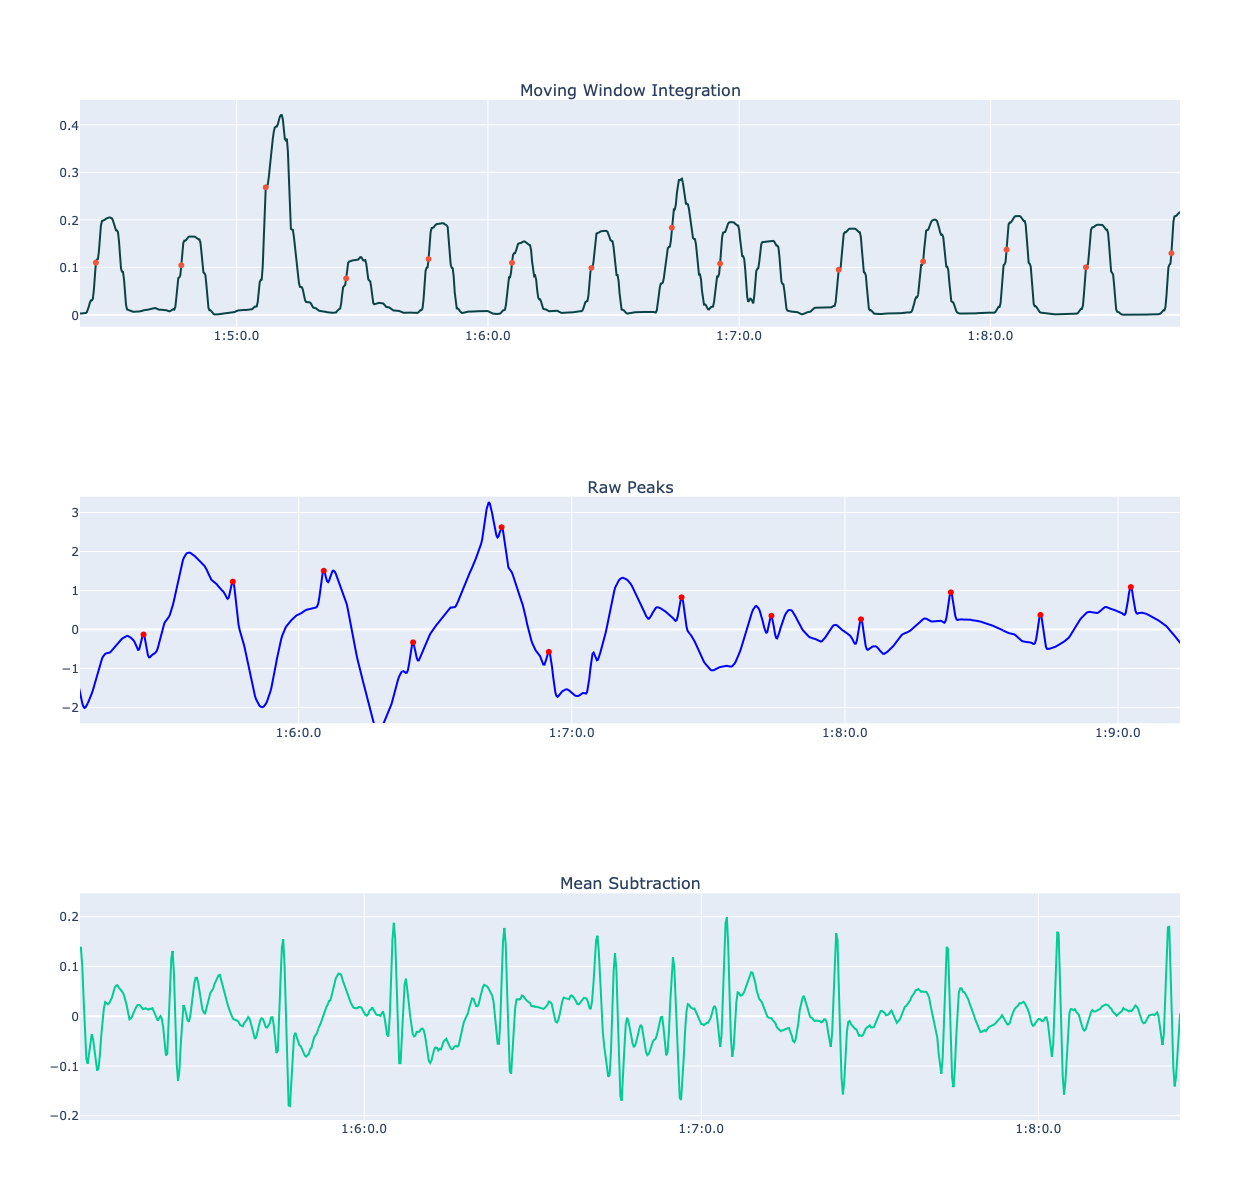

In [85]:
# Moving Window Integration and Raw Peaks
spline = 4
res = 1000
max_x, max_y, peaks_x, peaks_y, interpolated_peak_x, interpolated_peak_y,max_ids = interpolation_spline(fiducial_point_dict['Window Length: 25'], 
                                                                                               sample1.time, sample1.values, spline, res)
i = 6
fig4 = make_subplots(
    rows=3, cols=1,
    subplot_titles=("Moving Window Integration"," Raw Peaks ", 'Mean Subtraction'))

#fig4.add_trace(go.Scatter(line= dict(color='orange'),x=sample1.time, y = squared,name='Squared',showlegend=False),row=1, col=1)

fig4.add_trace(go.Scatter(line= dict(color='#0a4345'),x=sample1.time, y = y_mw_dict['MW Integration W: 25'],name='MWI',showlegend=False),row=1, col=1)
fig4.add_trace(go.Scatter(mode = 'markers',x=sample1.time[fiducial_point_dict['Window Length: 25']], 
                          y = y_mw_dict['MW Integration W: 25'][fiducial_point_dict['Window Length: 25']],
                          name='MWI',showlegend=False),row=1, col=1)
fig4.add_trace(go.Scatter(x=x[0:len(x)-cut_pts['Window '+str(i)]], y= prepro_data['Window '+str(i)],
                                   name = 'Baseline Removal Window '+str(i), showlegend=False,),row=3, col=1)


fig4.add_trace(go.Scatter(line= dict(color='blue'),x=sample1.time, y = sample1.values,name='Peaks in MWI',showlegend=False),row=2, col=1)
fig4.add_trace(go.Scatter(mode='markers',marker=dict(color='red'), x=peaks_x, y = peaks_y, name='Peaks In Raw Data',showlegend=False),row=2, col=1)

fig4.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),
                    xaxis2 = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),
                    xaxis3 = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis))

fig4.update_layout(xaxis_range=[79000,85000], xaxis2_range=[79000,85000],xaxis3_range=[79000,85000], yaxis_range=[-0.001,0.085], yaxis2_range=[-0.5,0.68])
fig4.update_layout(height=1200,width = 1300)

# Analytical Solution for peaks in interpolation method

In [86]:
"""
spline=4;
res = 5000
#max_x, max_y, peaks_x, peaks_y, interpolated_peak_x, interpolated_peak_y = interpolation_spline(fiducial_point_dict['Window Length: 14'], 
                                                                                          #     sample1.time, sample1.values, spline, res)
spline=4;
res = 5000
max_x3, max_y3, peaks_x3, peaks_y3, interpolated_peak_x3, interpolated_peak_y3 = interpolation_spline(fiducial_point_dict['Window Length: 14'], 
                                                                                               sample1.time, sample1.values, 3, res)
                                                                                               
                                                                                               """

"\nspline=4;\nres = 5000\n#max_x, max_y, peaks_x, peaks_y, interpolated_peak_x, interpolated_peak_y = interpolation_spline(fiducial_point_dict['Window Length: 14'], \n                                                                                          #     sample1.time, sample1.values, spline, res)\nspline=4;\nres = 5000\nmax_x3, max_y3, peaks_x3, peaks_y3, interpolated_peak_x3, interpolated_peak_y3 = interpolation_spline(fiducial_point_dict['Window Length: 14'], \n                                                                                               sample1.time, sample1.values, 3, res)\n                                                                                               \n                                                                                               "

In [87]:
"""
f = go.Figure()

f.add_trace(go.Scatter(line = dict(color = 'blue'), x=sample1.time,y=sample1.values, name='Raw Data'))
f.add_trace(go.Scatter(mode='markers',marker=dict(color = '#26E31A', size = 8), x = max_x,y=max_y,name='Analytical Solution'))
f.add_trace(go.Scatter(mode='markers',marker=dict(color = 'green' ,size = 6), x = peaks_x, y=peaks_y, name=' Collected Peak Interpolation '+str(res)+'Hz'))

for h in range(0,len(max_x)):
    f.add_trace(go.Scatter(mode='lines',line=dict(color='#FE4384'), x = interpolated_peak_x['peak: '+str(h)], 
                               y = interpolated_peak_y['peak: '+str(h)], showlegend= False))


f.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,
                     width=1250,height=600)

f.update_layout(title="Pan Tompkins Interpolated Peaks       Moving Average Window = 14 samples     Analytical Solution ", 
                         xaxis_title="Time", yaxis_title= 'Signal', font=dict(family="Avenir",size=16,color="Black"));
                         """

'\nf = go.Figure()\n\nf.add_trace(go.Scatter(line = dict(color = \'blue\'), x=sample1.time,y=sample1.values, name=\'Raw Data\'))\nf.add_trace(go.Scatter(mode=\'markers\',marker=dict(color = \'#26E31A\', size = 8), x = max_x,y=max_y,name=\'Analytical Solution\'))\nf.add_trace(go.Scatter(mode=\'markers\',marker=dict(color = \'green\' ,size = 6), x = peaks_x, y=peaks_y, name=\' Collected Peak Interpolation \'+str(res)+\'Hz\'))\n\nfor h in range(0,len(max_x)):\n    f.add_trace(go.Scatter(mode=\'lines\',line=dict(color=\'#FE4384\'), x = interpolated_peak_x[\'peak: \'+str(h)], \n                               y = interpolated_peak_y[\'peak: \'+str(h)], showlegend= False))\n\n\nf.update_layout(xaxis = dict(tickmode = \'array\', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,\n                     width=1250,height=600)\n\nf.update_layout(title="Pan Tompkins Interpolated Peaks       Moving Average Window = 14 samples     Analytical Solution ", \n          

In [88]:
#f.show()

In [89]:
# Raw Peaks and Third Order Spline Peaks 
max_x, max_y, peaks_x, peaks_y, interpolated_peak_x, interpolated_peak_y, max_idxs = interpolation_spline(fiducial_point_dict['Window Length: 25'], 
                                                                                               sample1.time, sample1.values, spline, res)

#fig4 = make_subplots(
#    rows=2, cols=1,
#    subplot_titles=("Raw Peaks"," Analytical Solution "))

fig4 = go.Figure()

#fig4.add_trace(go.Scatter(line= dict(color='orange'),x=sample1.time, y = squared,name='Squared',showlegend=False),row=1, col=1)
#fig4.add_trace(go.Scatter(line= dict(color='blue'), x=sample1.time, y = sample1.values,name='Peaks in Raw Data',showlegend=False),row=2, col=1)
#fig4.add_trace(go.Scatter(mode='markers',marker=dict(color='red', size=9), x= sample1.time[max_idxs], y = sample1.values[max_idxs], name='Peaks In Raw Data',showlegend=False),row=2, col=1)

fig4.add_trace(go.Scatter(line= dict(color='blue'), x=sample1.time, y = sample1.values,name='Peaks in MWI',showlegend=False))


for j in range(0,len(interpolated_peak_x)):
    fig4.add_trace(go.Scatter(line= dict(color='green'), x=interpolated_peak_x['peak: '+str(j)], y = interpolated_peak_y['peak: '+str(j)], name='Peaks in MWI',showlegend=False))

    
fig4.add_trace(go.Scatter(mode='markers',marker=dict(color='red', size=9), x=max_x, y = max_y, name='Peaks In Raw Data',showlegend=False))
fig4.add_trace(go.Scatter(mode='markers',marker=dict(color='orange', size=7), x=sample1.time[max_idxs], y = sample1.values[max_idxs], name='Raw Peaks',showlegend=False))

fig4.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),
                    xaxis2 = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis));


In [90]:
fig4.update_layout(xaxis_range=[79000,85000], yaxis_range=[-0.5,0.68])
#fig4.update_layout(xaxis_range=[79000,85000], xaxis2_range=[79000,85000], yaxis_range=[-0.5,0.68], yaxis2_range=[-0.5,0.68])
fig4.update_layout(height=600,width = 1300);

#### Time Differences with different amount of control points and re sampling frequency 

## Interpolation with different window lenghts in the moving window integration

In [ ]:
interp = go.Figure()
spline = 4
max_x_dict= {};max_y_dict= {}
res = 1000 


for N in lengths: 
    
    max_x_dict['Window: '+str(N)], max_y_dict['Window: '+str(N)], peaks_x, peaks_y, interpolated_peak_x, interpolated_peak_y, max_idx = interpolation_spline(
        fiducial_point_dict['Window Length: '+str(N)], sample1.time, sample1.values, spline, res)
    
    interp.add_trace(go.Scatter(mode = 'lines', line= dict(color='blue'),x=sample1.time, y=sample1.values,showlegend=False,visible=False))
    interp.add_trace(go.Scatter(mode = 'markers', x= max_x_dict['Window: '+str(N)], y=max_y_dict['Window: '+str(N)],
                               name = 'Peaks ',showlegend=False,visible=False))
    

    
interp.data[5].visible = True

steps = []
start = 0
for length in lengths:
    step = dict(
        method="update",
        args=[{"visible": [False] * len(interp.data)},
              {"title": 'Peaks Found           Window Length: ' + str(length)}],  # layout attribute
    )
    step["args"][0]["visible"][start] = True # Toggle i'th trace to "visible"
    step["args"][0]["visible"][start+1] = True # Toggle i'th trace to "visible"
    start = start + 2
    steps.append(step)
    
sliders = [dict(active=5, currentvalue={"prefix": "n: "}, pad={"t": 50}, steps=steps)]
interp.update_layout(sliders=sliders);
#interp.update_layout(xaxis_range=[79000,85000]);
interp.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,width=1300,height=600);


In [ ]:
#interp.show()

In [ ]:
#fig_raw.show()

## Mean Subtraction and wavelet transform 

### We do the following just to check how good are the PT results 

In [ ]:
mean = average_filter(15,sample1.values)

In [ ]:
mean_peaks,_ = find_peaks(sample1.values-mean,distance=100)

In [ ]:
fig9 = go.Figure()

fig9.add_trace(go.Scatter(mode = 'lines', line= dict(color='blue'),x=sample1.time, y=sample1.values,name='Raw Data',showlegend=True))
#fig9.add_trace(go.Scatter(mode = 'lines', x=sample1.time, y=mean, name = 'Mean Average', showlegend = True))
fig9.add_trace(go.Scatter(mode = 'lines', x=sample1.time, y=sample1.values-mean, name = 'Mean Subtraction', showlegend = True))
fig9.update_layout(xaxis_range=[79000,85000]);
fig9.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,width=1200,height=600);

### Interpolating with the mean subtraction peaks

In [ ]:
amount_of_peaks = len(max_x_w)

In [ ]:
spline=4;
res = 5000
max_x_w, max_y_w, peaks_x_w, peaks_y_w, interpolated_peak_x_w, interpolated_peak_y_w,max_idxs_m = interpolation_spline(mean_peaks, sample1.time, sample1.values, 4, res)

In [ ]:
### Comparing peaks of PT with window N

In [ ]:
#fig10.show()

### Comparing Pan Tompkins and mean average substraction with all windows in Moving Window Integration

In [ ]:
#Visually missing peaks

fig10 = go.Figure()
missing_mean_p_dict ={};  missing_pt_p_dict={};
spline=4;
res = 5000


for N in lengths: 
    #print(N)
    missing_pt_p, missing_mean_p = find_missing_peaks(max_x_dict['Window: '+str(N)], max_x_w, True)
    missing_pt_p_dict['window_length_'+str(N)] = missing_pt_p
    missing_mean_p_dict['window_length_'+str(N)] = missing_mean_p
    
    fig10.add_trace(go.Scatter(line= dict(color='blue'),x=sample1.time, y=sample1.values,name='Raw Data',showlegend=True, visible = False))
    

    fig10.add_trace(go.Scatter(mode='markers',marker=dict(size=12),x=max_x_w, y= max_y_w, name = 'Mean Peaks', 
                               showlegend=True, visible = False))
    fig10.add_trace(go.Scatter(mode='markers',marker=dict(size=10,color='#21B626'), x = max_x_dict['Window: '+str(N)], 
                              y = max_y_dict['Window: '+str(N)], name = 'P.T. Peaks WL: '+str(N),showlegend=True, 
                              visible = False))
    fig10.add_trace(go.Scatter(mode='markers',marker=dict(size=7,color='orange'), x = max_x_dict['Window: '+str(N)][missing_mean_p], 
                               y= max_y_dict['Window: '+str(N)][missing_mean_p], name = 'Missing Mean Peaks', showlegend=True, visible = False))
    
    fig10.add_trace(go.Scatter(mode='markers',marker=dict(size=7,color='#00FCF5'),x = max_x_w[missing_pt_p] , y= max_y_w[missing_pt_p], 
                              name = 'Missing P.T. Peaks', showlegend=True, visible = False))

fig10.data[5].visible = True

steps = []
start = 0
for i in range(0,len(lengths)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig10.data)},
              {"title": "Peaks identified with PT window length "+str(lengths[i])+ '   Amount of Mean + Wavelet Missing Peaks: '+
               str(len(missing_mean_p_dict['window_length_'+str(lengths[i])])) +'   Amount of PT Missing Peaks: '+ 
               str(len(missing_pt_p_dict['window_length_'+str(lengths[i])]))}],  # layout attribute
    )
    step["args"][0]["visible"][start] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][start+1] = True
    step["args"][0]["visible"][start+2] = True
    step["args"][0]["visible"][start+3] = True
    step["args"][0]["visible"][start+4] = True
    
    start = start+5
    steps.append(step)
    
sliders = [dict(active=5, currentvalue={"prefix": "n: "}, pad={"t": 50}, steps=steps)]
fig10.update_layout(sliders=sliders);
fig10.update_layout(xaxis_range=[79000,85000]);
fig10.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,width=1200,height=600); 

In [ ]:
fig10.show()

In [ ]:
sample1 = raw_sample_(28,20,28,40,1,False)
fig = sample1.fig
fig.update_layout(xaxis = dict(tickmode = 'array', tickvals = sample1.ticks_values, ticktext = sample1.time_format_axis),autosize=False,width=1250,
                  height=600,showlegend=False,title="Raw Data ", xaxis_title="Time", yaxis_title= 'Signal', 
                  font=dict(family="Avenir",size=14,color="Black"))